In [291]:
import random
import os
import re
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image, ImageDraw
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import metrics
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.model_selection import train_test_split

# Get Data

In [2]:
test = pd.read_csv('test_simplified.csv')

In [332]:
# test

In [3]:
# Get names of all train csv files with the pattern match below
fnames = glob('train_simplified/*.csv')

In [164]:
rows = 200
# Get n rows from all the csv files and append them into one dataframe
train_df = pd.DataFrame(columns=pd.read_csv(fnames[0], nrows=20).columns)
for name in fnames:
    data = pd.read_csv(name, nrows=rows)
    train_df = train_df.append(data)
train_df = train_df.reset_index().drop('index', axis=1)
# Get only those which were correctly recognized
train_df = train_df[train_df['recognized'] == True]
train_df['drawing'] = train_df['drawing'].apply(ast.literal_eval)

In [165]:
train_df.shape
# train_df['recognized'].value_counts()

(62590, 6)

# Draw Sample

In [166]:
train_df.sample(10)

,countrycode,drawing,key_id,recognized,timestamp,word
20780,US,"[[[0, 15, 45, 74, 98, 126, 144, 158, 168, 167,...",5195909119868928,True,2017-03-21 23:59:58.677920,ear
62715,US,"[[[11, 114, 221, 253, 255, 255, 253], [12, 12,...",5715858993184768,True,2017-03-29 15:09:14.599620,bench
43297,AU,"[[[44, 73, 88, 90, 81, 76, 70, 49, 31, 30, 34]...",6409799233175552,True,2017-03-10 02:04:53.649330,microphone
14254,HR,"[[[38, 37, 21, 8, 0, 0], [0, 11, 48, 87, 140, ...",4823576777588736,True,2017-03-05 19:31:22.521970,jail
15784,US,"[[[0, 46, 185, 224, 228, 212, 198, 168, 145, 1...",4843567887417344,True,2017-03-24 21:32:33.949100,purse
29168,US,"[[[52, 52, 57], [91, 212, 255]], [[51, 24, 19,...",5287394158837760,True,2017-01-29 00:20:11.466030,flower
15054,US,"[[[47, 44], [255, 147]], [[42, 29, 0, 26, 47],...",4846770444042240,True,2017-01-31 19:34:36.849900,yoga
23040,US,"[[[94, 77, 65, 60, 60, 64, 72, 85, 99, 107, 11...",4958614156476416,True,2017-03-24 14:35:08.627900,eyeglasses
49339,US,"[[[10, 0, 2, 13, 23, 36, 46, 159, 200, 212, 22...",6205515656855552,True,2017-03-01 19:38:28.997270,baseball bat
54428,TH,"[[[0, 2, 17, 34, 145, 216, 229, 241, 251, 255,...",5386791978795008,True,2017-03-14 14:50:16.321590,fireplace


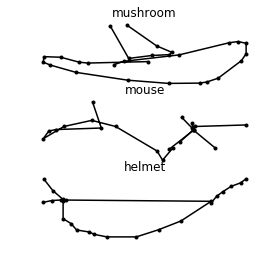

In [167]:
n_samp = 3
train_df_sample = train_df.sample(n_samp)
plt.figure(figsize=(4,4))
for i in range(n_samp):
    draw = train_df_sample.iloc[i]['drawing']
    label = train_df_sample.iloc[i]['word']
    plt.subplot(n_samp,1,i+1)
    for stroke in draw:
        plt.plot(stroke[0], stroke[1], marker='.', color='black')
        plt.title(label)
        plt.axis('off')
plt.show()    

# Convert drawings to images

In [277]:
def draw_it(raw_strokes, output_height, output_width):
    image = Image.new("P", (255,255)
#                       , color=1
            )
    image_draw = ImageDraw.Draw(image)

    for stroke in raw_strokes:
        for i in range(len(stroke[0])-1):

            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=255, width=6)
    # Reduce image size
    image = image.resize((output_height,output_width),Image.ANTIALIAS)
    
    return np.array(image)

In [353]:
output_height = 64
output_width = 64
train_df['img'] = train_df[['drawing']].apply(lambda x: draw_it(x['drawing'], output_height, output_width), axis=1)

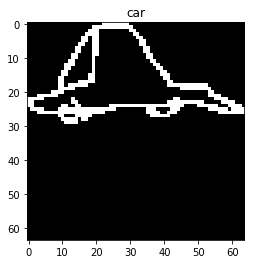

In [354]:
# Show an image
ind = 100
plt.imshow(train_df.iloc[ind]['img'],cmap='gray')
plt.title(train_df.iloc[ind]['word'])
plt.show()

# Create a baseline CNN

In [355]:
batch_size = 10
num_classes = len(fnames)
epochs = 12

### Data Preprocessing

In [356]:
# Shuffle the data
random.seed(111)
train_df = train_df.sample(train_df.shape[0])

In [357]:
# input image dimensions
img_rows, img_cols = output_height, output_width
input_shape = (img_rows, img_cols)

In [358]:
# Reshape the array
imgArr = np.vstack(train_df['img'].values).flatten().reshape((train_df['img'].shape[0], img_rows, img_cols))

In [359]:
# In Keras, the layers used for two-dimensional convolutions expect pixel values with the dimensions [width][height][pixels] for TF.
# In the case of RGB, the first dimension pixels would be 3 for the red, green and blue components and it would be like having 3 image inputs for every color image. In this case, the pixel values are gray scale, the pixel dimension is set to 1.
imgArr = imgArr.reshape(imgArr.shape[0], img_rows, img_cols, 1).astype('float32')

In [360]:
y_train = train_df['word']

In [361]:
# Convert class labels from categorical to numerical
unique_classes_list = y_train.unique()
map_class_to_numeric = {k: v for v, k in enumerate(y_train.unique())}
map_numeric_to_class = {v: k for k, v in map_class_to_numeric.iteritems()}
y_train_numeric = y_train.apply(lambda x: map_class_to_numeric[x])

# convert class vectors to binary class matrices
y_train_one_hot = keras.utils.to_categorical(y_train_numeric, num_classes)
num_classes = y_train_one_hot.shape[1]

In [362]:
X_train, X_test, y_train, y_test = train_test_split(imgArr, y_train_one_hot, test_size=0.2)

In [363]:
def top_3_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

### Model Architecture

In [367]:
num_filters = 8 # num of channels / filters
def baseline_conv_model(num_filters):
    model = Sequential()
    model.add(Conv2D(num_filters, (10,10), input_shape=(img_rows,img_cols,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(num_filters*2, (10,10), input_shape=(img_rows,img_cols,1), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', top_3_accuracy, 'categorical_crossentropy'])
    return model

In [368]:
model = baseline_conv_model(num_filters)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_103 (Conv2D)          (None, 55, 55, 8)         808       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 27, 27, 8)         0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 27, 27, 8)         0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 18, 18, 16)        12816     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 9, 9, 16)          0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 9, 9, 16)          0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 1296)              0         
__________

In [369]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 50072 samples, validate on 12518 samples
Epoch 1/500
 - 764s - loss: 16.0194 - acc: 0.0055 - top_3_accuracy: 0.8176 - categorical_crossentropy: 16.0194 - val_loss: 16.0322 - val_acc: 0.0050 - val_top_3_accuracy: 0.9819 - val_categorical_crossentropy: 16.0322
Epoch 2/500
 - 795s - loss: 14.4218 - acc: 0.0053 - top_3_accuracy: 0.7370 - categorical_crossentropy: 14.4218 - val_loss: 5.8255 - val_acc: 0.0038 - val_top_3_accuracy: 0.0121 - val_categorical_crossentropy: 5.8255
Epoch 3/500
 - 764s - loss: 5.7782 - acc: 0.0062 - top_3_accuracy: 0.0168 - categorical_crossentropy: 5.7782 - val_loss: 5.7172 - val_acc: 0.0105 - val_top_3_accuracy: 0.0256 - val_categorical_crossentropy: 5.7172
Epoch 4/500
 - 773s - loss: 5.6391 - acc: 0.0141 - top_3_accuracy: 0.0353 - categorical_crossentropy: 5.6391 - val_loss: 5.5485 - val_acc: 0.0171 - val_top_3_accuracy: 0.0429 - val_categorical_crossentropy: 5.5485
Epoch 5/500
 - 797s - loss: 5.4464 - acc: 0.0229 - top_3_accuracy: 0.0553 - categorical_

KeyboardInterrupt: 

In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          epochs=500, batch_size=1000, verbose=2)
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

In [131]:
# X_train.shape

(27200, 50, 50, 1)